# Ordering Kewords using Pretrained Embeddings

We use th FastText Bag Of Tricks model pretrained on **Common Crawl** and **Wikipedia** to generate the word embeddings. <br>
Link to the paper [here](https://arxiv.org/pdf/1607.01759.pdf). <br>
Link to the 157 pretrained embeddings [here](https://fasttext.cc/docs/en/crawl-vectors.html).

In [2]:
import fasttext
import fasttext.util
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from scipy.stats import entropy
from sklearn.metrics import mutual_info_score 
from Scripts.util import findAllIterationsInString
from IPython.display import clear_output

[nltk_data] Downloading package wordnet to /home/jcl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jcl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Load the FastText Model

In [3]:
# fasttext.util.download_model('en', if_exists='ignore')  # English
ft_model = fasttext.load_model('Models/cc.en.300.bin')

##### Load Data

In [4]:
labeled_concept_pair_df = pd.read_csv("Data/labeled_concept_pair_dataset.csv")
labeled_concept_pair_df.tail()

,kw1,kw2,label
25996,software testing debugging,combinational synthesis,0
25997,combinational synthesis,power management,0
25998,software fault tolerance,pcb design layout,0
25999,pcb design layout,formal method,0
26000,documentation,pcb design layout,0


In [5]:
kw_test = labeled_concept_pair_df.iloc[1,0]
print(kw_test)
embedding_dim = ft_model.get_word_vector(kw_test).shape[0]
print("Embedding size:", embedding_dim)

general reference
Embedding size: 300


In [6]:
ft_model.get_nearest_neighbors(kw_test)[:3]

[(0.613596498966217,
  'QQJCgAEACwJAAAAEAASAAAIZwABEBhIsKBBAQAEGiSQUCEBARAdDgQwoKJCiBEJUqw44CJGhxstDsSYkSFHhx8RahQ5MWFEhQ0TjiQZk6NIhB8b2uzIMKfOnQBoxgzJ82NLokVlakQqUOJSoAsnQo1q0qZTg0MHBgQAIfkECQoABAAsCQAAABAAEgAACGkAARAYSJAggIMEBSAsSADAgIcCCQiYGHGgw4cDIk6kaBBjxoEbFXaEmDBkxYsVNwJQiPCgS4sHKbr0'),
 (0.5904855728149414,
  'ČeskýDanskDeutschΕλληνικάEnglishEspañolFrançaisעבריתMagyarItaliano日本語한국어NederlandsPolskiPortuguêsРусскийSvenska中文'),
 (0.5851196646690369,
  'Bags.sizingInchesEURUSAUK8.50354.528.6335.552.58.88365.539.0036.563.59.13376.549.3837.574.59.50387.559.62538.585.59.875398.5610.004096.510.125419.5710.2542107.510.3754310.5810.5043.5118.510.6254411.5910.87544.5121011.004512.510.511.125461311')]

Okay, so it does not handle very well multiple word sentences, let's try doing the maxpooling ourselves:

In [7]:
## Average Pool Embedding
def avg_pool_embed(kw_list, embed_func):
    return np.mean([embed_func(part) for part in kw_list.split(" ")], axis = 0)
avg_embedding_test = avg_pool_embed(kw_test, ft_model.get_word_vector)
avg_embedding_test.shape

(300,)

In [8]:
from scipy.spatial import distance

## We can see that sentence_vector is very close to our average pooling method.
distance.cosine(ft_model.get_sentence_vector(kw_test), avg_embedding_test)

0.0024306774139404297

In [9]:
## Average Pool Embeddings for kw1 and kw2
temp_res = pd.DataFrame(labeled_concept_pair_df.apply(lambda x: (avg_pool_embed(x.kw1, ft_model.get_word_vector), avg_pool_embed(x.kw2, ft_model.get_word_vector)), axis=1, result_type='expand'))
labeled_concept_pair_df[["avg_pool_embedding_1", "avg_pool_embedding_2"]] = temp_res

Sentence Vector Explained [here](https://stackoverflow.com/questions/54181163/fasttext-embeddings-sentence-vectors). In sum, they normalize their vectors before computing the average ;).

In [10]:
## Average Pool Embeddings for kw1 and kw2
temp_res = pd.DataFrame(labeled_concept_pair_df.apply(lambda x: (ft_model.get_sentence_vector(x.kw1), ft_model.get_sentence_vector(x.kw2)), axis=1, result_type='expand'))
labeled_concept_pair_df[["sentence_vector_embedding_1", "sentence_vector_embedding_2"]] = temp_res

In [11]:
labeled_concept_pair_df.tail()

,kw1,kw2,label,avg_pool_embedding_1,avg_pool_embedding_2,sentence_vector_embedding_1,sentence_vector_embedding_2
25996,software testing debugging,combinational synthesis,0,"[0.022371108, -0.005886328, 0.027992472, 0.041...","[0.04251424, 0.018713767, 0.02182541, 0.007658...","[0.029621912, -0.008412714, 0.03842728, 0.0606...","[0.08096917, 0.030264342, 0.04064402, 0.016720..."
25997,combinational synthesis,power management,0,"[0.04251424, 0.018713767, 0.02182541, 0.007658...","[-0.070760734, 0.029085558, 0.07695586, 0.0309...","[0.08096917, 0.030264342, 0.04064402, 0.016720...","[-0.07305679, 0.037602574, 0.10327606, 0.03084..."
25998,software fault tolerance,pcb design layout,0,"[-0.0015693331, 0.042603467, -0.012904748, 0.0...","[0.11601115, -0.012827079, 0.03209356, 0.07732...","[0.011055365, 0.043711685, -0.021244038, 0.046...","[0.07769436, -0.01909836, 0.050779857, 0.05521..."
25999,pcb design layout,formal method,0,"[0.11601115, -0.012827079, 0.03209356, 0.07732...","[0.024535254, -0.0059768907, 0.005824997, 0.07...","[0.07769436, -0.01909836, 0.050779857, 0.05521...","[0.028043732, -0.0068222457, 0.0077669974, 0.0..."
26000,documentation,pcb design layout,0,"[0.015205305, 0.026330382, 0.012304179, 0.0220...","[0.11601115, -0.012827079, 0.03209356, 0.07732...","[0.0409104, 0.0708428, 0.033104822, 0.05937038...","[0.07769436, -0.01909836, 0.050779857, 0.05521..."


In [21]:
from sklearn.metrics.pairwise import cosine_distances
cos_mat_1 = cosine_distances(np.array([np.array(el) for el in labeled_concept_pair_df.iloc[:,4]]))
cos_mat_2 = cosine_distances(np.array([np.array(el) for el in labeled_concept_pair_df.iloc[:,6]]))

In [28]:
most_similar_kw = labeled_concept_pair_df.iloc[np.argsort(cos_mat_1[0]), 1]
print("Word being analyzed:", labeled_concept_pair_df.iloc[0,1])
set(most_similar_kw[:100])

Word being analyzed: general reference


{'context specific language',
 'general conference proceeding',
 'general literature',
 'general programming language',
 'general reference'}

In [29]:
most_similar_kw = labeled_concept_pair_df.iloc[np.argsort(cos_mat_2[0]), 1]
print("Word being analyzed:", labeled_concept_pair_df.iloc[0,1])
set(most_similar_kw[:100])

Word being analyzed: general reference


{'general conference proceeding',
 'general literature',
 'general programming language',
 'general reference',
 'reference model',
 'reference work'}

Better similarity results in the second case

#### Create Labeled Data

In [14]:
def kl_div(x, y):
    """Function that computes the kl divergence of two discrete distributions"""
    idx1 = np.intersect1d(np.where(x>0), np.where(y>0))
    idx2 = np.where(x==0)

    return (x[idx1]*np.log(x[idx1]/y[idx1])).sum() + y[idx2].sum()

def ComputeKwDistribution(corpus, kw, window_size, normalized = True):
    ## Lowering varialbes in case its not done by preprocessing
    corpus = corpus.lower()
    kw     = kw.lower()

    ## Find all positions of occurences of a substring in the corpus
    occur_list = findAllIterationsInString(corpus, kw)

    ## Divide by window size to get positions:
    pos_in_window = np.array(occur_list)/window_size
    pos_in_window = np.floor(pos_in_window).astype(int)

    ## Count occurences in a window 
    unique_pos, freq = np.unique(pos_in_window, return_counts=True)
    distribution = np.array([0 for i in range(0, np.ceil(len(corpus)/window_size).astype(int))])#bins of distrib
    distribution[unique_pos] = freq

    return distribution/distribution.sum() if normalized and distribution.sum()!=0 else distribution

def ExtractKeywordOrderFromCorpus(labeled_data_dict, corpus, ccs_list, corpus_size, window_size, verbose=False):
    if(verbose):
        print(corpus[:1000] if len(corpus) > 1000 else corpus)
        print(ccs_list)

    ## Looping on corpus size:
    curr_corpus = corpus
    found_atleast_one_kw = False
    while(len(curr_corpus) >= corpus_size):
        working_corpus = curr_corpus[:corpus_size]
        
        ## Find valid keyword pairs
        for kw_pair in ccs_list:
            concept_root, concept_leaf = kw_pair
            if(concept_root in working_corpus and concept_leaf in working_corpus):
                found_atleast_one_kw = True
        
                ## Randomly chooses the order of keywords (kw)
                label, kw1, kw2 = None, None, None
                if(np.random.uniform(0,1)>0.5):
                    label = 0 # leaf then root is 0
                    kw1 = concept_leaf
                    kw2 = concept_root

                else:
                    label = 1 # root then leaf is 1
                    kw2 = concept_leaf
                    kw1 = concept_root
                    

                ## Computing the distributions of both concepts
                dist1 = ComputeKwDistribution(working_corpus, kw1, window_size=window_size, normalized = True)
                dist2 = ComputeKwDistribution(working_corpus, kw2, window_size=window_size, normalized = True)

                if(verbose):
                    print(dist1)
                    print(dist2)

                ## Padding distributions to same length
                len_d1, len_d2 = len(dist1), len(dist2)
                if(len_d1 < len_d2):
                    dist1 = np.pad(dist1, (0, len_d2-len_d1), mode="constant", constant_values=0)
                elif(len_d1 > len_d2):
                    dist2 = np.pad(dist2, (0, len_d1-len_d2), mode="constant", constant_values=0)

                ## Computing entropy, KL divergence, ratio and Mutual Information for both distributions:
                H1_var = entropy(dist1)
                H2_var = entropy(dist2)
                kl_div1 = kl_div(dist1, dist2).sum()
                kl_div2 = kl_div(dist2, dist1).sum()
                ratio   = kl_div1/kl_div2 if kl_div2 != 0 else np.nan
                MI_var  = mutual_info_score(dist1, dist2) 

                ## Store information
                labeled_data_dict["label"].append(label)
                labeled_data_dict["kw1"].append(kw1)
                labeled_data_dict["kw2"].append(kw2)
                labeled_data_dict["distrib1"].append(dist1)
                labeled_data_dict["distrib2"].append(dist2)
                labeled_data_dict["H1"].append(H1_var)
                labeled_data_dict["H2"].append(H2_var)
                labeled_data_dict["DKL_1"].append(kl_div1)
                labeled_data_dict["DKL_2"].append(kl_div2)
                labeled_data_dict["ratio"].append(ratio)
                labeled_data_dict["MI"].append(MI_var)

                ## Clear warnings
                if(not verbose):
                    clear_output(wait=True)

        

        curr_corpus = curr_corpus[corpus_size:]# Sliding window style for corpus


    return 1 if found_atleast_one_kw else np.nan

Test of new implementation

In [10]:
str_var = "French fries I love french fries, this is why I cook them so often! Please let me eat french fries indefinitely. Yes, I am addicted to french fries (you did not ask me). (French fries!!)"
kw      = "French fries"

res_1   = ComputeKwDistribution(str_var, kw, window_size=100, normalized = False)
print(len(str_var), len(res_1), res_1)

186 2 [3 2]


##### Create labeled data on abstracts

In [13]:
## Dict stores the created labeled data for future experiments
labeled_data_dict = {"label": [], "kw1": [], "kw2": [], "distrib1": [], "distrib2": [], "H1": [], "H2": [], "DKL_1": [], "DKL_2": [], "ratio": [], "MI": []}


agg_ccs_df.ft_body_len = agg_ccs_df['ft_body_processed'].apply(len)
agg_ccs_bigbodies_df = agg_ccs_df[agg_ccs_df.ft_body_len >= 1e5]
print("remaining bodies", agg_ccs_bigbodies_df.shape)

return_na_count = agg_ccs_bigbodies_df.apply(lambda el: ExtractKeywordOrderFromCorpus(labeled_data_dict, corpus=el.ft_body_processed, ccs_list=el.high_Importance_concept_roots_and_leafs, corpus_size=corpus_size, window_size=window_size, verbose=False), axis = 1)

print("number of concept not found:", return_na_count.isna().sum(), " out of {} articles.".format(agg_ccs_bigbodies_df.shape[0]))

labeled_data_bodies_df = pd.DataFrame.from_dict(labeled_data_dict)
labeled_data_bodies_df.tail()

number of concept not found: 154  out of 956 articles.


,label,kw1,kw2,distrib1,distrib2,H1,H2,DKL_1,DKL_2,ratio,MI
19765,0,web mining,information system,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.693147,1.386294,1.096574,0.326713,3.356380,0.004275
19766,1,information system,world wide web,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.098612,0.000000,1.000000,1.000000,1.000000,0.000003
19767,1,human-centered computing,human computer interaction hci,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.000000,NaN,0.007907
19768,1,information system,social network,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.693147,0.000000,1.000000,1.000000,1.000000,0.000002
19769,1,information system,world wide web,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, ...",0.693147,1.609438,1.516291,-0.366516,-4.137035,0.011062


In [16]:
labeled_data_bodies_df.describe()

,label,H1,H2,DKL_1,DKL_2,ratio,MI
count,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,18882.000000,19770.000000
mean,0.497016,1.435011,1.446073,1.201980,1.182062,-8.241825,0.002483
std,0.500004,1.575353,1.572960,1.316070,1.302875,73.076084,0.005678
min,0.000000,0.000000,0.000000,-0.366516,-0.367811,-4274.328672,0.000001
25%,0.000000,0.000000,0.000000,1.000000,1.000000,-0.006005,0.000006
50%,0.000000,0.693147,0.693147,1.000000,1.000000,1.000000,0.000054
75%,1.000000,2.369382,2.397895,1.000000,1.000000,1.000000,0.003979
max,1.000000,5.988555,6.148306,7.109250,7.109250,6908.065642,0.218466


##### Gradient Boosting

In [18]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection  import cross_validate, GridSearchCV
from sklearn  import metrics   #Additional scklearn functions
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


processed_data = labeled_data_bodies_df.drop(columns=["kw1", "kw2", "distrib1", "distrib2"]).dropna(subset="ratio")

X_train, X_test, y_train, y_test = train_test_split(processed_data.drop(columns="label"), processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [19]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [20]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.6274338453234785

In [21]:
best_model = gsearch1.best_estimator_

In [22]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [23]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


##### Performance analysis on test dataset

In [24]:
y_pred=best_model.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 1, 1])

In [25]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.6187


Text(0, 0.5, 'Feature Importance Score')

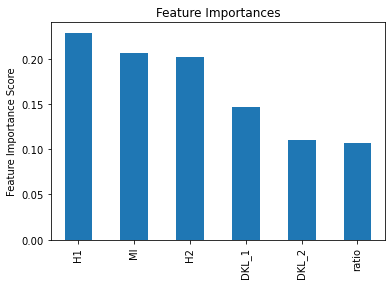

In [26]:
feat_imp = pd.Series(best_model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

##### Plot confusion matrix:

In [27]:
cm = confusion_matrix(y_test, y_pred)

In [28]:
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[1050  857]
 [ 583 1287]]


<AxesSubplot:>

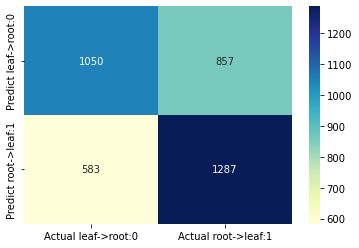

In [29]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual leaf->root:0', 'Actual root->leaf:1'], 
                                 index=['Predict leaf->root:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59      1907
           1       0.60      0.69      0.64      1870

    accuracy                           0.62      3777
   macro avg       0.62      0.62      0.62      3777
weighted avg       0.62      0.62      0.62      3777



##### Save Models

In [31]:
pickle.dump(best_model, open("Models/naive_gridsearch.pkl", "wb"))

In [23]:
best_model = pickle.load(open("Models/naive_gridsearch.pkl", "rb"))
best_model

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=700, random_state=10, subsample=0.8)